In [ ]:
# Copyright 2018 The TensorFlow Hub Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

##### Note

Derived and modified from https://github.com/tensorflow/hub/blob/master/examples/colab/tf2_object_detection.ipynb

In [1]:
import os
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub

from absl import app
from absl import flags
from absl import logging

from PIL import Image as Img
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont

MODELS = {
  'inception_resnet_v2': 'https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1', 
  'mobilenet_v2': 'https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1'
}

2024-07-13 21:32:21.245685: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-13 21:32:21.267573: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-13 21:32:21.267607: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-13 21:32:21.279712: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def get_image_paths(dir_path):
  files = [x for x in os.listdir(dir_path) if x.lower().endswith(('.png', '.jpg', '.jpeg'))]
  print("Total Image Files: {}".format(len(files)))
  return files


def save_image(img_array, save_path):
  print("Saving Image: {}".format(save_path))
  image = Img.fromarray(img_array)
  image.save(save_path, format="JPEG", quality=90)


def load_image(image_path, new_height=256, new_width=256, resize=False):
  img = tf.io.read_file(image_path)
  img = tf.image.decode_image(img, channels=3)
  if resize:
    img = tf.image.resize(img, [new_height, new_width], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  return img

In [3]:
def draw_bounding_box_on_image(image, ymin, xmin, ymax, xmax, dupe, color, font, thickness=4, display_str_list=()):
  """Adds a bounding box to an image."""
  draw = ImageDraw.Draw(image)
  im_width, im_height = image.size
  (left, right, top, bottom) = (xmin * im_width, xmax * im_width, ymin * im_height, ymax * im_height)
  draw.line([(left, top), (left, bottom), (right, bottom), (right, top), (left, top)], width=thickness, fill=color)

  # If the total height of the display strings added to the top of the bounding
  # box exceeds the top of the image, stack the strings below the bounding box
  # instead of above.
  display_str_heights = [font.getbbox(ds)[3] for ds in display_str_list]
  # Each display_str has a top and bottom margin of 0.05x.
  total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

  if top > total_display_str_height:
    text_bottom = top
  else:
    text_bottom = top + total_display_str_height

  print(display_str_list)
  # Reverse list and print from bottom to top.
  for display_str in display_str_list[::-1]:
    bbox = font.getbbox(display_str)
    text_width, text_height = bbox[2], bbox[3]
    margin = np.ceil(0.05 * text_height)

    if dupe:
      left = left + 400
    
    draw.rectangle([(left, text_bottom - text_height - 2 * margin), (left + text_width, text_bottom)], fill=color)
    draw.text((left + margin, text_bottom - text_height - margin), display_str, fill="white", font=font)
    text_bottom -= text_height - 2 * margin


def draw_boxes(image, boxes, class_names, scores, max_boxes=5, min_score=0.1):
  """Overlay labeled boxes on an image with formatted scores and label names."""
  colors = list(ImageColor.colormap.values())

  try:
    font = ImageFont.truetype("/usr/share/fonts/truetype/noto/NotoMono-Regular.ttf", 50)
  except IOError:
    print("Font not found, using default font.")
    font = ImageFont.load_default()

  label_positions = []
  for i in range(min(boxes.shape[0], max_boxes)):
    if scores[i] >= min_score:
      box = boxes[i]
      ymin, xmin, ymax, xmax = tuple(box)
      display_str = "{}: {}%".format(class_names[i].decode("ascii"), int(100 * scores[i]))
      color = colors[hash(class_names[i]) % len(colors)]
      image_pil = Img.fromarray(np.uint8(image)).convert("RGB")
     
      dupe = False
      if label_positions.count(hash(str(box))) > 0:
        print('Duplicate box: {}'.format(box))
        dupe = True
      else: 
        label_positions.append(hash(str(box)))

      draw_bounding_box_on_image(image_pil, ymin, xmin, ymax, xmax, dupe, color, font, display_str_list=[display_str])
      np.copyto(image, np.array(image_pil))
  return image

In [4]:
def get_model(model_id):
  MODEL_URL = MODELS.get(model_id)
  print("Configuring Model: {}".format(MODEL_URL))
  signatures = hub.load(MODEL_URL).signatures
  print("Model Signatures: {}".format(signatures))
  return signatures['default']

In [5]:
print("TensorFlow Version: {}".format(tf.__version__))
PROJECT_ROOT = os.path.dirname(os.path.abspath('__file__'))
IMAGES_DIR_PATH = os.path.join(PROJECT_ROOT, 'images')
OUTPUT_DIR_PATH = os.path.join(PROJECT_ROOT, 'output')
#print("GPUs Available: {}".format(tf.config.list_physical_devices('GPU')))

detector = get_model('mobilenet_v2')

print("Processing Images: {}".format(IMAGES_DIR_PATH))
for file_name in get_image_paths(IMAGES_DIR_PATH):
    image_path = os.path.join(IMAGES_DIR_PATH, file_name)
    
    print("Loading Image: {}".format(image_path))
    image = load_image(image_path)
    image_tensor = tf.image.convert_image_dtype(image, tf.float32)[tf.newaxis, ...]

    result = detector(image_tensor)
    result = {key: value.numpy() for key,value in result.items()}
    print("Found {} objects.".format(len(result["detection_boxes"])))
    image_with_boxes = draw_boxes(image.numpy(), result["detection_boxes"], result["detection_class_entities"], result["detection_scores"])

    save_path = os.path.join(OUTPUT_DIR_PATH, file_name)
    save_image(image_with_boxes, save_path)

TensorFlow Version: 2.16.2
Configuring Model: https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
2024-07-13 21:32:36.442266: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_COMPAT_NOT_SUPPORTED_ON_DEVICE: forward compatibility was attempted on non supported HW
2024-07-13 21:32:36.442290: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:134] retrieving CUDA diagnostic information for host: e0576d421d16
2024-07-13 21:32:36.442296: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:141] hostname: e0576d421d16
2024-07-13 21:32:36.442342: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:165] libcuda reported version is: 545.23.6
2024-07-13 21:32:36.442361: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:169] kernel reported version is: 535.183.1
2024-07-13 21:32:36.442366: E external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:251] kernel version 535.183.1 does not match

Model Signatures: _SignatureMap({'default': <ConcreteFunction () -> Dict[['detection_class_labels', TensorSpec(shape=(None, 1), dtype=tf.int64, name=None)], ['detection_class_names', TensorSpec(shape=(None, 1), dtype=tf.string, name=None)], ['detection_class_entities', TensorSpec(shape=(None, 1), dtype=tf.string, name=None)], ['detection_boxes', TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)], ['detection_scores', TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)]] at 0x745824169E90>})
Processing Images: /tf/object_detection/images
Total Image Files: 1
Loading Image: /tf/object_detection/images/pixel.jpg
Found 100 objects.
['Cat: 94%']
['Cat: 12%']
['Cat: 10%']
['Cat: 10%']
Saving Image: /tf/object_detection/output/pixel.jpg


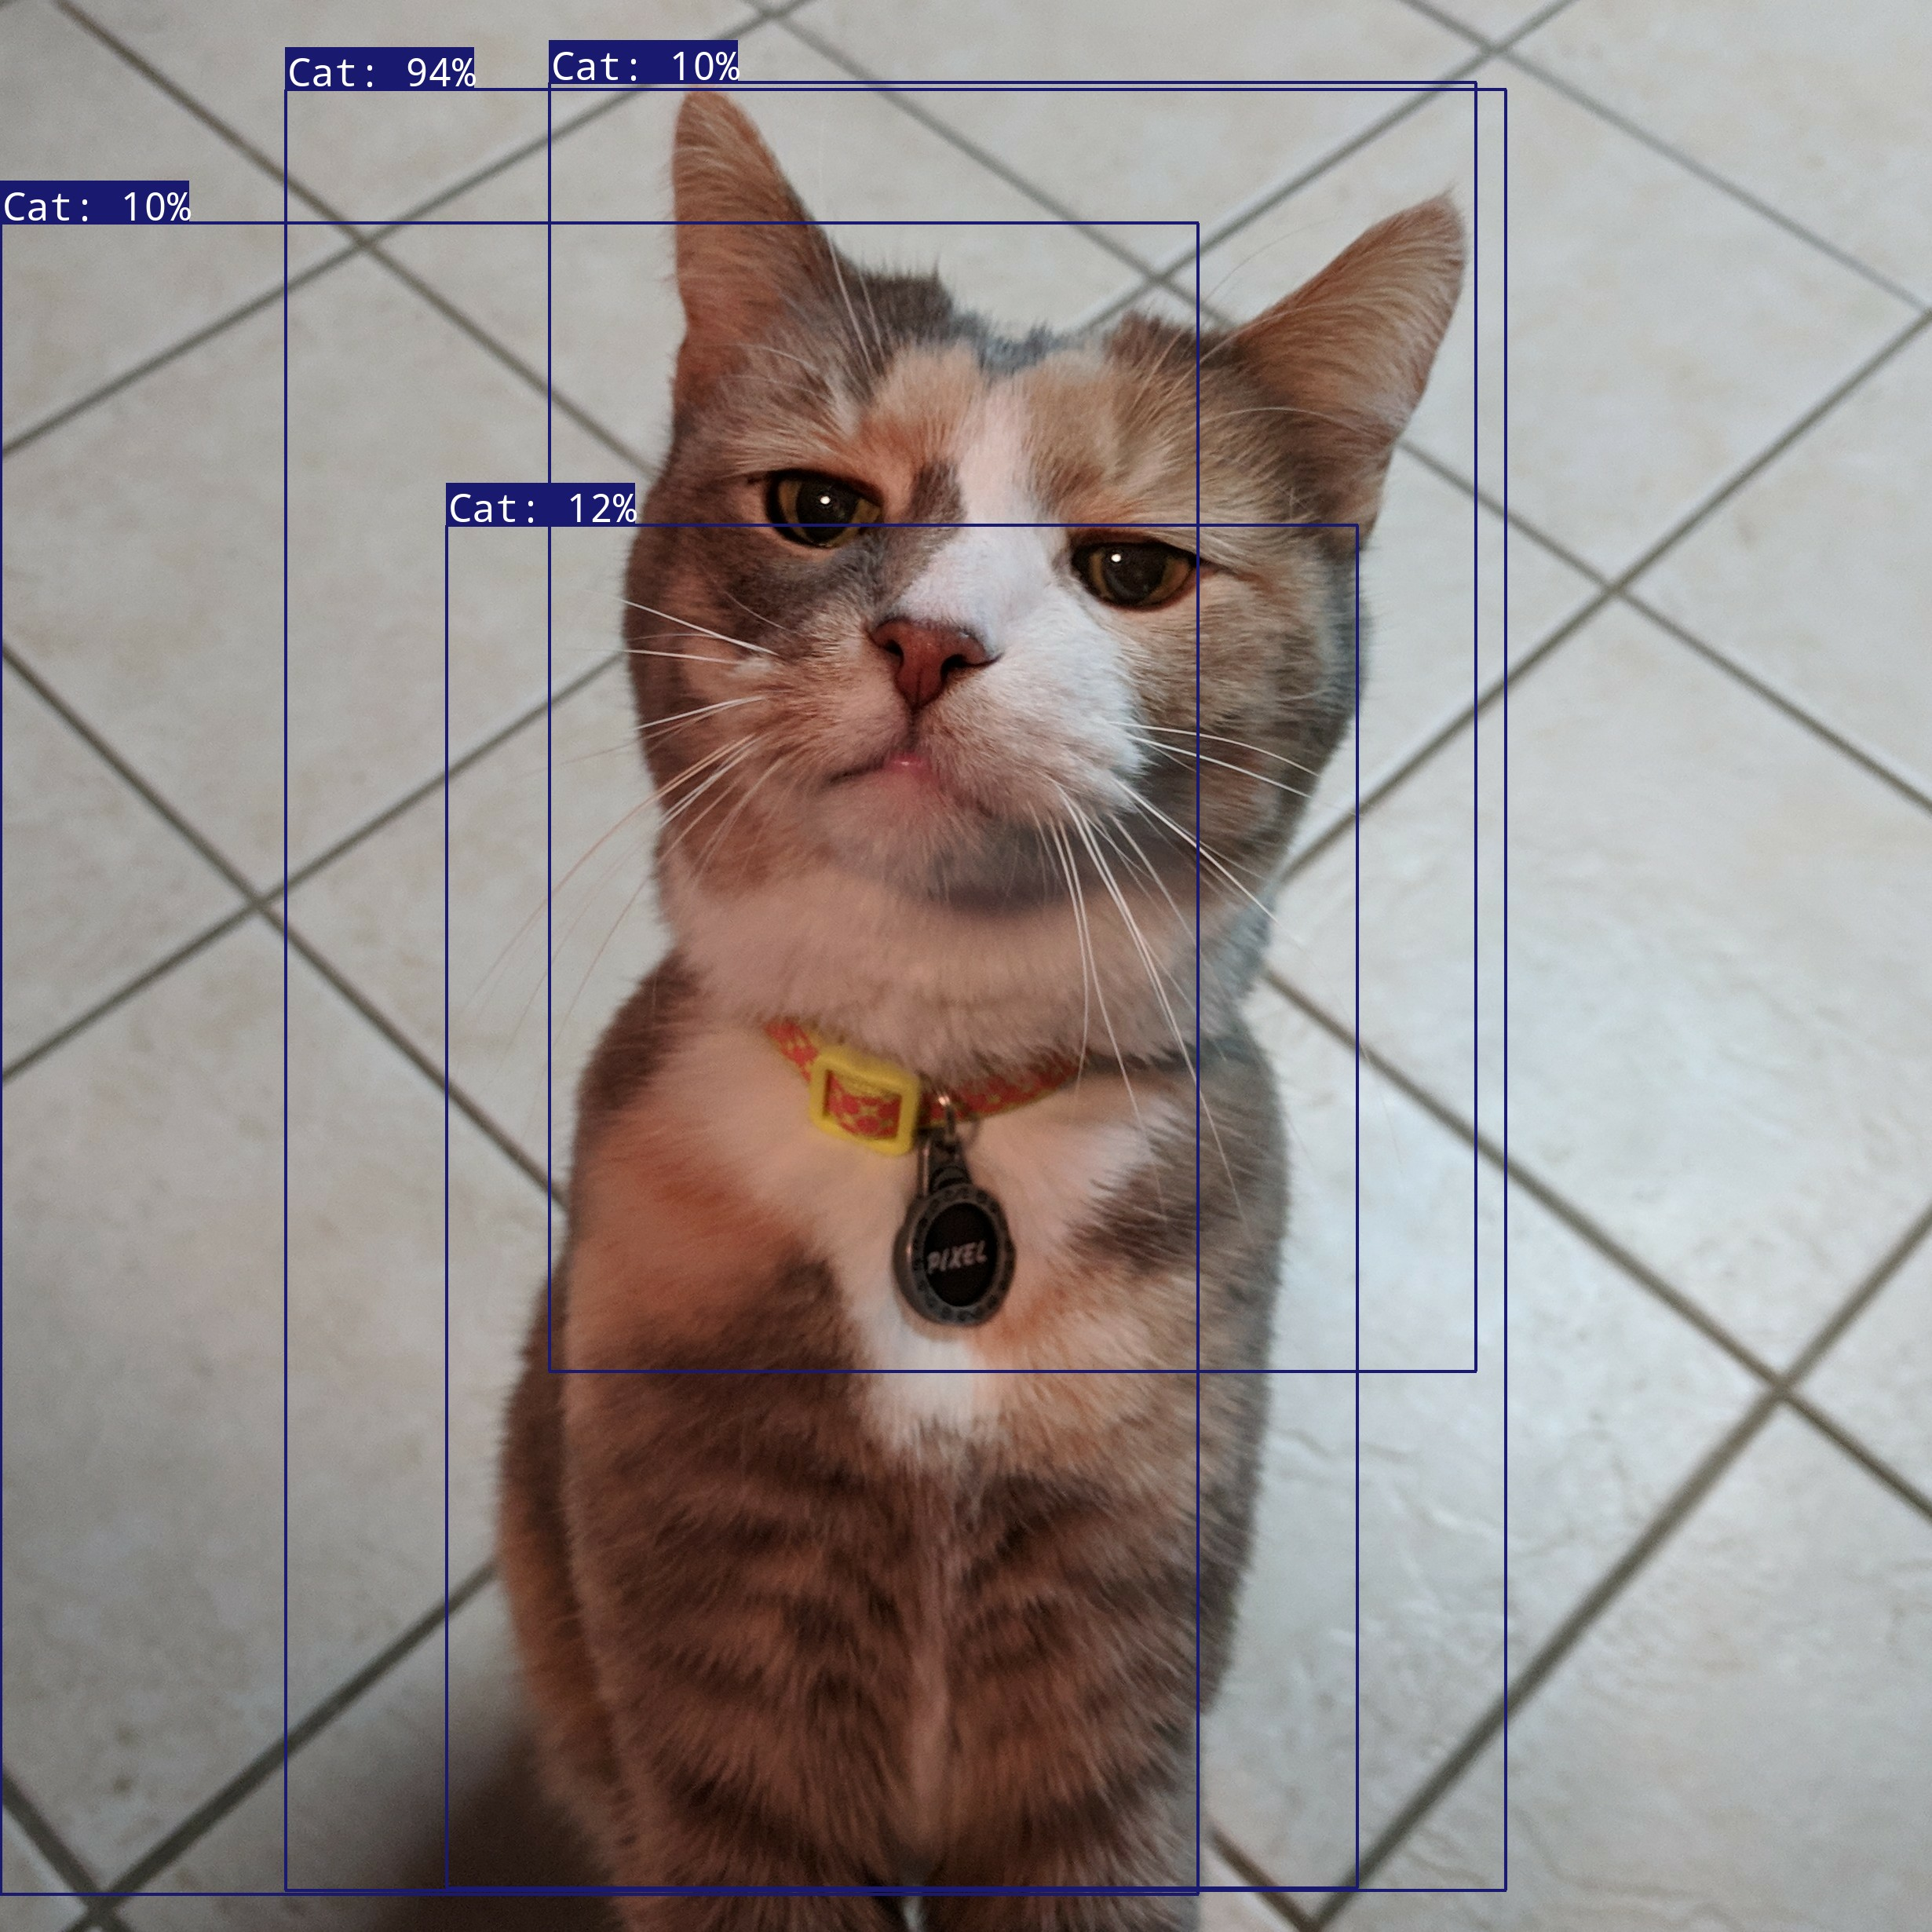

In [6]:
from IPython.display import Image
Image(filename=os.path.join(OUTPUT_DIR_PATH, file_name))